In [1]:
import re
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from nltk.stem import SnowballStemmer

In [2]:
train_data = pd.read_csv('data/wassa_train.csv')
test_data = pd.read_csv('data/wassa_test.csv')
val_data = pd.read_csv('data/wassa_val.csv')

In [3]:
train_data

,id,tweet,emotion
0,1929,Kinda wished I watched mischievous kiss before...,joy
1,4049,When you forget to mention you were bought dre...,anger
2,5405,@FreyaLynn @donniewahlberg yep! jimmy buffett ...,neutral
3,5900,"@philcampbell blue skies? where, it's still gr...",neutral
4,3712,Some moving clips on youtube tonight of the vi...,anger
...,...,...,...
5996,5407,@koifusionpdx i was so close to the tacos...on...,neutral
5997,496,@Fatumoriginal there's no sitcom better! If u ...,sadness
5998,499,@Mysteri759 @Ren102e906 @slb42jcb @swoozyqyah ...,sadness
5999,1784,Watch this amazing live.ly broadcast by @ittzd...,joy


In [4]:
def preprocess_text(text):
    result = text.lower()
    result = result.strip()
    result = re.result = re.sub(r"http\S+", "", result)
    result = re.sub('\S*@\S*\s?', '', result)
    result = unidecode.unidecode(result)
    stop_words = stopwords.words("english")
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("english")

    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += word
            stemmed_sentence += " "

    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

In [5]:

def preprocess_text_list(text_list):
  for i,text in enumerate(text_list):
    text_list[i] = preprocess_text(text_list[i])

In [6]:
train_texts = train_data["tweet"].tolist()
val_texts = val_data["tweet"].tolist()
test_texts = test_data["tweet"].tolist()


train_labels = train_data["emotion"].tolist()
val_labels = val_data["emotion"].tolist()
test_labels = test_data["emotion"].tolist()

train_labels[:10]
     

['joy',
 'anger',
 'neutral',
 'neutral',
 'anger',
 'joy',
 'neutral',
 'sadness',
 'sadness',
 'neutral']

In [7]:
preprocess_text_list(train_texts)
preprocess_text_list(val_texts)
preprocess_text_list(test_texts)

train_texts[:10]

['kinda wished watched mischievous kiss playful kiss ',
 'forget mention bought dreamboys tickets ',
 'yep  jimmy buffett ftw     jimmy needs tweet words wisdom every morning ',
 'blue skies   s still grey hazy window ',
 'moving clips youtube tonight vigil held tulsa metropolitan baptist church  terencecruther  justice  sadness ',
 'makes successful  happy forever ',
 'morning hon  breakfast  cant decide ',
 'standard candice starting show pout  startasyoumeantogoon  gbbo ',
 '   would frown bit  folding arms  why every time m need assistance someone expects lil   ',
 'someone make cofffeeeeeee  ']

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

In [9]:
X_train = tokenizer.texts_to_sequences(train_texts)
X_val = tokenizer.texts_to_sequences(val_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train)
X_val = pad_sequences(X_val, maxlen=X_train.shape[1])
X_test = pad_sequences(X_test, maxlen=X_train.shape[1])


In [10]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['emotion'])
y_val = label_encoder.transform(val_data['emotion'])
y_test = label_encoder.transform(test_data['emotion'])

In [11]:
embedding_dim = 50
vocab_size = len(tokenizer.word_index) + 1

In [12]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=X_train.shape[1]))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5


188/188 [==============================] - 3s 9ms/step - loss: -18.4054 - accuracy: 0.2000 - val_loss: -29.9486 - val_accuracy: 0.2000
Epoch 2/5
188/188 [==============================] - 1s 7ms/step - loss: -39.5076 - accuracy: 0.2000 - val_loss: -48.9124 - val_accuracy: 0.2000
Epoch 3/5
188/188 [==============================] - 1s 7ms/step - loss: -58.1265 - accuracy: 0.2000 - val_loss: -67.3767 - val_accuracy: 0.2000
Epoch 4/5
188/188 [==============================] - 1s 7ms/step - loss: -76.4001 - accuracy: 0.2000 - val_loss: -85.5372 - val_accuracy: 0.2000
Epoch 5/5
188/188 [==============================] - 1s 7ms/step - loss: -94.5365 - accuracy: 0.2000 - val_loss: -103.8404 - val_accuracy: 0.2000


In [26]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

24/24 [==============================] - 0s 2ms/step - loss: -104.2169 - accuracy: 0.2000
Test Accuracy: 20.00%


In [27]:
new_texts = ["I'm so happy right now!", "This is really frustrating."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=X_train.shape[1])

predictions = model.predict(new_padded)
predicted_labels = label_encoder.inverse_transform([1 if prediction > 0.5 else 0 for prediction in predictions.flatten()])

print(f'Predictions: {predicted_labels}')

1/1 [==============================] - 0s 286ms/step
Predictions: ['fear' 'fear']


In [28]:
new_texts = ["Kinda wished I watched mischievous kiss before."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=X_train.shape[1])

predictions = model.predict(new_padded)
predicted_labels = label_encoder.inverse_transform([1 if prediction > 0.5 else 0 for prediction in predictions.flatten()])

print(f'Predictions: {predicted_labels}')

1/1 [==============================] - 0s 15ms/step
Predictions: ['fear']


# SVM


In [15]:
 vectorizer = TfidfVectorizer()
 vectorizer.fit(train_texts)

TfidfVectorizer()

In [16]:
vectorized_train_texts = vectorizer.transform(train_texts)
vectorized_val_texts = vectorizer.transform(val_texts)
vectorized_test_texts = vectorizer.transform(test_texts)

In [17]:
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

In [18]:
encoded_test_labels[:19]

array([4, 0, 3, 4, 3, 2, 3, 4, 3, 1, 0, 4, 4, 1, 4, 2, 4, 4, 3])

In [19]:
test_labels[:19]

['sadness',
 'anger',
 'neutral',
 'sadness',
 'neutral',
 'joy',
 'neutral',
 'sadness',
 'neutral',
 'fear',
 'anger',
 'sadness',
 'sadness',
 'fear',
 'sadness',
 'joy',
 'sadness',
 'sadness',
 'neutral']

In [20]:
svm_model = svm.SVC(probability=True)
svm_model.fit(vectorized_train_texts, encoded_train_labels)

SVC(probability=True)

In [21]:
y_pred = svm_model.predict_log_proba(vectorized_val_texts)
y_pred

array([[-5.85416914e+00, -2.63627493e+00, -3.63380936e-01,
        -5.56407927e+00, -1.48567337e+00],
       [-7.49632382e+00, -9.91921514e-03, -8.38859956e+00,
        -4.78348005e+00, -7.23517136e+00],
       [-1.99820953e+01, -4.98667589e-05, -1.66998895e+01,
        -9.96359680e+00, -1.28132457e+01],
       ...,
       [-6.84557420e-01, -2.54391590e+00, -3.07973540e+00,
        -1.34844967e+00, -2.19360020e+00],
       [-2.34510287e+00, -3.74860008e+00, -2.61674525e+00,
        -3.88213804e-01, -2.04558558e+00],
       [-4.99705095e+00, -5.71336505e+00, -3.67249722e+00,
        -1.03906617e-01, -2.76116272e+00]])

In [22]:
acc = accuracy_score(encoded_val_labels, np.argmax(y_pred, axis=1))
precision = precision_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="micro")
recall = recall_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="micro")
f1 = f1_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="micro")
print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")

Model has acc = 0.8893333333333333
, precision = 0.8893333333333333
, recall = 0.8893333333333333
, f1_score = 0.8893333333333333



In [95]:
y_pred = svm_model.predict_log_proba(vectorized_test_texts)
y_pred

array([[-3.11334586e+01, -3.04928062e+01, -3.13817050e+01,
        -3.07716549e+01, -1.53987934e-13],
       [-1.33391992e-02, -7.36702277e+00, -9.79543951e+00,
        -4.47235597e+00, -6.77427656e+00],
       [-4.38574428e+00, -4.73532243e+00, -7.50134064e+00,
        -2.36677302e-02, -6.43508679e+00],
       ...,
       [-2.67931765e+01, -1.75443062e-06, -1.72189593e+01,
        -1.34337030e+01, -1.51771581e+01],
       [-1.47937391e+01, -6.37159571e-04, -1.33281573e+01,
        -7.38421357e+00, -1.11783247e+01],
       [-8.98330589e-01, -5.33671361e-01, -7.12574569e+00,
        -5.51180906e+00, -6.52920672e+00]])

In [92]:
acc = accuracy_score(encoded_test_labels, np.argmax(y_pred, axis=1))
precision = precision_score(encoded_test_labels, np.argmax(y_pred, axis=1), average="macro")
recall = recall_score(encoded_test_labels, np.argmax(y_pred, axis=1), average="macro")
f1 = f1_score(encoded_test_labels, np.argmax(y_pred, axis=1), average="macro")
print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")

Model has acc = 0.864
, precision = 0.8682200934235779
, recall = 0.8640000000000001
, f1_score = 0.8654829178175897



In [110]:
from sklearn.metrics import confusion_matrix
def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")

In [111]:
def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")


In [123]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.rcParams.update({'font.size': 20})
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [124]:
y_pred = svm_model.predict(vectorized_test_texts)

In [125]:

labels = ['joy', 'anger', 'fear', 'sadness', 'neutral']

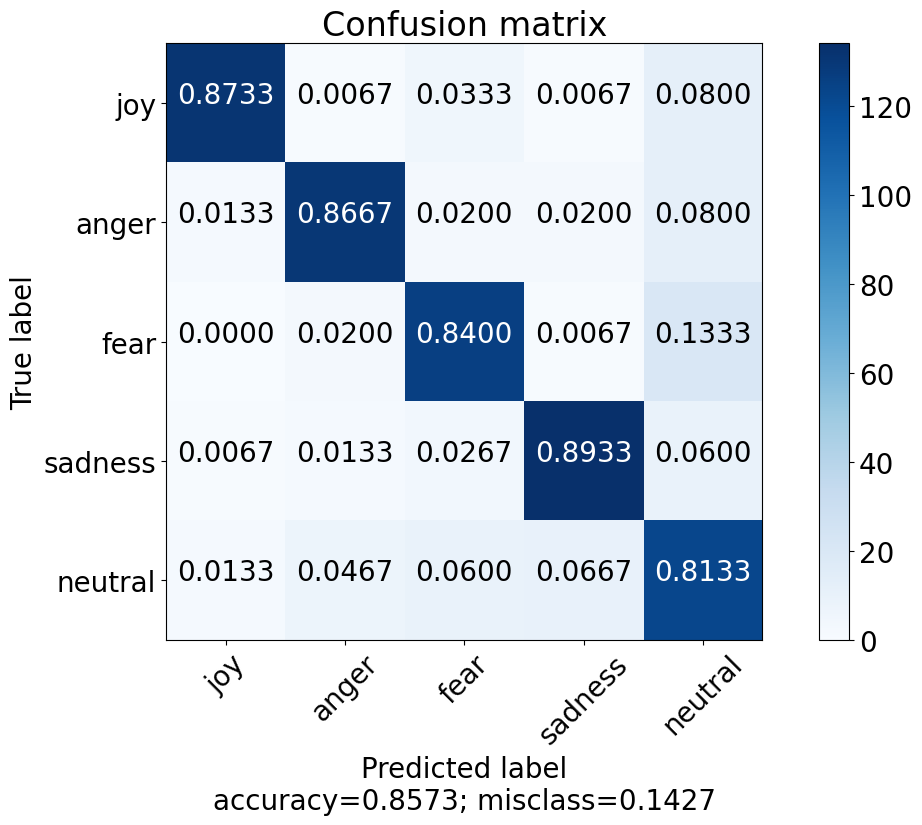

In [126]:

y_pred = label_encoder.inverse_transform(y_pred)
cm = confusion_matrix(test_labels, y_pred, labels=labels)
plot_confusion_matrix(cm, labels)

In [127]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

       anger       0.91      0.87      0.89       150
        fear       0.86      0.84      0.85       150
         joy       0.96      0.87      0.92       150
     neutral       0.70      0.81      0.75       150
     sadness       0.90      0.89      0.90       150

    accuracy                           0.86       750
   macro avg       0.87      0.86      0.86       750
weighted avg       0.87      0.86      0.86       750



In [87]:
y_pred = svm_model.predict(vectorized_test_texts)

In [59]:
emotions = [
    "I hate getting up, it's so annoying.",
    "I love cats and their sweet noses.",
    "I put up with my schoolmates.",
    "This movie made me feel so happy!",
    "The traffic jam today was frustrating.",
    "Spending time with friends always brings joy.",
    "I feel lonely when I'm alone at home.",
    "Excited about the upcoming vacation!",
    "I love spending time with friends and family. It brings me so much joy!",
    "The rude behavior of that person made me really angry.",
    "I'm feeling neutral about the upcoming changes at work.",
    "Today is just another neutral day for me.",
    "The constant delays and issues with the project are making me angry.",
    "Winning the lottery would bring me immense joy and happiness!",
    "I don't have a strong opinion on the matter; I'm feeling quite neutral.",
    "The news about the recent event left me in deep sadness.",
    "Losing a loved one is an experience filled with sadness and grief.",
    "I have a neutral stance on the current political situation.",
    "I'm so happy right now!", "This is really frustrating."
    "Feeling sad and lonely tonight.",
    "I can't contain my excitement!",
    "Angry about the recent events.",
    "Today is a wonderful day!",
    "Dealing with a lot of stress.",
    "The movie made me cry, but it was beautiful.",
    "I'm thrilled about the upcoming project.",
    "Feeling a bit anxious about the presentation."
]

for text in emotions:
    vectorized_text = vectorizer.transform([text])

    text_pred = svm_model.predict(vectorized_text)

    decoded_emotion = label_encoder.inverse_transform(text_pred)

    print(f"'{text}' : {decoded_emotion[0]}")

'I hate getting up, it's so annoying.' : neutral
'I love cats and their sweet noses.' : joy
'I put up with my schoolmates.' : neutral
'This movie made me feel so happy!' : joy
'The traffic jam today was frustrating.' : neutral
'Spending time with friends always brings joy.' : joy
'I feel lonely when I'm alone at home.' : neutral
'Excited about the upcoming vacation!' : fear
'I love spending time with friends and family. It brings me so much joy!' : joy
'The rude behavior of that person made me really angry.' : anger
'I'm feeling neutral about the upcoming changes at work.' : neutral
'Today is just another neutral day for me.' : neutral
'The constant delays and issues with the project are making me angry.' : anger
'Winning the lottery would bring me immense joy and happiness!' : joy
'I don't have a strong opinion on the matter; I'm feeling quite neutral.' : sadness
'The news about the recent event left me in deep sadness.' : sadness
'Losing a loved one is an experience filled with sadne

In [60]:
texts = []
predicted_emotions = []
probabilities = []

for text in emotions:
    vectorized_text = vectorizer.transform([preprocess_text(text)])
    text_pred_prob = svm_model.predict_proba(vectorized_text)
    text_pred = svm_model.predict(vectorized_text)
    decoded_emotion = label_encoder.inverse_transform(text_pred)
    
    texts.append(text)
    predicted_emotions.append(decoded_emotion[0])
    probabilities.append(max(text_pred_prob[0]))  # Assuming you want the probability of the predicted class

emotion_df = pd.DataFrame({'Text': texts, 'Predicted Emotion': predicted_emotions, 'Probability': probabilities})
emotion_df

,Text,Predicted Emotion,Probability
0,"I hate getting up, it's so annoying.",neutral,0.529682
1,I love cats and their sweet noses.,joy,0.999722
2,I put up with my schoolmates.,anger,0.620478
3,This movie made me feel so happy!,joy,0.999446
4,The traffic jam today was frustrating.,neutral,0.613071
5,Spending time with friends always brings joy.,joy,0.618825
6,I feel lonely when I'm alone at home.,neutral,0.991056
7,Excited about the upcoming vacation!,neutral,0.487228
8,I love spending time with friends and family. ...,joy,0.894446
9,The rude behavior of that person made me reall...,anger,0.998289


In [61]:
new_text = "Today is a wonderful excitement day!"


vectorized_new_text = vectorizer.transform([preprocess_text(new_text)])

predictions_proba_svm = svm_model.predict_proba(vectorized_new_text)

predicted_label_svm = label_encoder.inverse_transform(predictions_proba_svm.argmax(axis=1))[0]
probability_svm = predictions_proba_svm.max()

print(f"Text: {new_text}\nPredicted Label (SVM): {predicted_label_svm}\nProbability (SVM): {probability_svm:.2f}")

Text: Today is a wonderful excitement day!
Predicted Label (SVM): joy
Probability (SVM): 0.71


In [45]:
joblib.dump(svm_model, 'svm_model/svm_model.joblib')
joblib.dump(vectorizer, 'svm_model/svm_vectorizer.joblib')
joblib.dump(label_encoder, 'svm_model/svm_label_encoder.joblib')

FileNotFoundError: [Errno 2] No such file or directory: 'svm_model/svm_model.joblib'

In [22]:
loaded_svm_model = joblib.load('svm_model/svm_model.joblib')
loaded_svm_vectorizer = joblib.load('svm_model/svm_vectorizer.joblib')
loaded_svm_label_encoder = joblib.load('svm_model/svm_label_encoder.joblib')

In [32]:
new_text = "Today is a wonderful excitement day!"

vectorized_new_text = loaded_svm_vectorizer.transform([preprocess_text(new_text)])

predictions_proba_svm = loaded_svm_model.predict_proba(vectorized_new_text)

predicted_label_svm = loaded_svm_label_encoder.inverse_transform(predictions_proba_svm.argmax(axis=1))[0]
probability_svm = predictions_proba_svm.max()

print(f"Text: {new_text}\nPredicted Label (SVM): {predicted_label_svm}\nProbability (SVM): {probability_svm:.2f}")

Text: Today is a wonderful excitement day!
Predicted Label (SVM): joy
Probability (SVM): 0.70


In [34]:
new_text = "I'm afraid of spiders, they're so big!"

vectorized_new_text = loaded_svm_vectorizer.transform([preprocess_text(new_text)])

predictions_proba_svm = loaded_svm_model.predict_proba(vectorized_new_text)

predicted_label_svm = loaded_svm_label_encoder.inverse_transform(predictions_proba_svm.argmax(axis=1))[0]
probability_svm = predictions_proba_svm.max()

print(f"Text: {new_text}\nPredicted Label (SVM): {predicted_label_svm}\nProbability (SVM): {probability_svm:.2f}")

Text: I'm afraid of spiders, they're so big!
Predicted Label (SVM): fear
Probability (SVM): 1.00
